In [1]:
import os
import pandas as pd
import numpy as np

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
# !pip install pydub
from pydub import AudioSegment, effects
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use('ggplot')

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [5]:
rav_path = "./Ravdess/audio_speech_actors_01-24/"

In [6]:
root_dir = "./Ravdess"

# Recursively search for .DS_Store files and delete them
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"{file_path} has been deleted.")

print("Deletion process completed.")


Deletion process completed.


In [2]:
#making the ravdess dataframe

In [7]:
ravdess_directory_list = os.listdir(rav_path)
file_path_list = []
gender_list = []
emotion_label_list = []

emotion_dictionary = {
    '03': 'happy',
    '01': 'neutral',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
}

for directory in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(rav_path, directory))
    for audio_file in actor_files:
        file_name_parts = audio_file.split('.')[0].split('-')
        key = file_name_parts[2]
        if key in emotion_dictionary:
            gender_code = int(file_name_parts[6])
            file_path_list.append(f"{rav_path}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_label_list.append(emotion_dictionary[key])

ravdess_dataframe = pd.DataFrame({
    'file_path': file_path_list,
    'gender_category': gender_list,
    'emotion_label': emotion_label_list
})

ravdess_dataframe.head()

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust


In [8]:
ravdess_dataframe['gender_category'].unique()

array(['female', 'male'], dtype=object)

In [9]:
ravdess_dataframe['emotion_label'].value_counts()

emotion_label
angry      192
fear       192
disgust    192
sad        192
happy      192
neutral     96
Name: count, dtype: int64

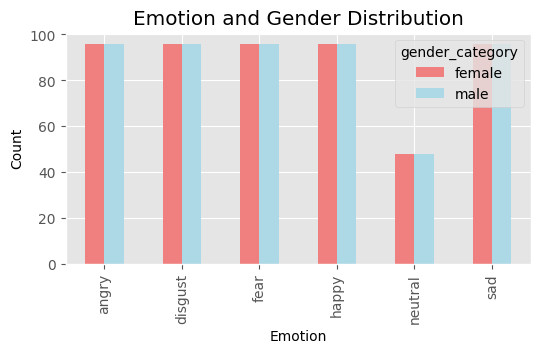

In [10]:
def plot_emotion_gender_distribution(dataframe): 
    count_table = dataframe.groupby(['emotion_label', 'gender_category']).count()
    pivot_table = count_table.pivot_table(index='emotion_label', columns='gender_category', values='file_path')

    pivot_table.plot(kind='bar', figsize=(6, 3), color=['lightcoral', 'lightblue'])  # Updated colors
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_emotion_gender_distribution(ravdess_dataframe)

In [11]:
def create_wave_plot(audio_data, sampling_rate, title_text):
    plt.figure(figsize=(8, 2))
    plt.title(title_text)
    librosa.display.waveshow(audio_data, sr=sampling_rate)
    plt.show()

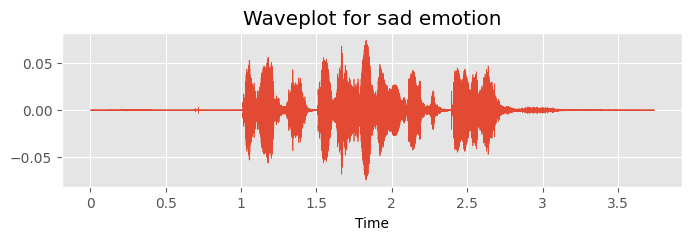

In [12]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(ravdess_dataframe.file_path[ravdess_dataframe.emotion_label == emotion_label])[1]
y, sr = librosa.load(path)

create_wave_plot(y, sr, title)
Audio(path)

In [13]:
ravdess_df_train = ravdess_dataframe[ravdess_dataframe['emotion_label']!='neutral']
ravdess_df_train

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
1050,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,disgust
1051,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,disgust
1052,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,sad
1053,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,happy


In [14]:
ravdess_df_train['emotion_label'].unique()

array(['angry', 'fear', 'disgust', 'sad', 'happy'], dtype=object)

In [3]:
# trying to extract simpler features like mfcc

In [15]:
mfcc_features_list = []
extracted_features_list = []
emotion_labels = []

for row in ravdess_df_train.itertuples(index=False):
    try: 
        _, sample_rate = librosa.load(path=row.file_path, sr=None) 
        raw_sound = AudioSegment.from_file(row.file_path) 
        normalized_sound = effects.normalize(raw_sound, headroom=0)
        normalized_x = np.array(normalized_sound.get_array_of_samples(), dtype='float32')

        mfcc_features = librosa.feature.mfcc(y=normalized_x, sr=sample_rate, n_mfcc=128)
        mfcc_features_mean = np.mean(mfcc_features.T, axis=0)
        extracted_features_list.append([mfcc_features_mean, row.emotion_label])
    except:
        print(f"Failed for path: {row.file_path}")

In [16]:
extracted_features_dataframe = pd.DataFrame(extracted_features_list, columns=('features', 'emotion_label'))
extracted_features_dataframe.tail()

,features,emotion_label
955,"[606.02527, 75.70522, 13.94076, 18.86165, 6.82...",disgust
956,"[639.45013, 66.4096, 11.9854965, 20.301847, 5....",disgust
957,"[655.0799, 88.06583, -0.2098536, 15.457284, 9....",sad
958,"[652.43317, 75.493805, -17.445332, 2.7181756, ...",happy
959,"[593.22766, 76.22169, -5.0607634, 12.962386, 1...",happy


In [17]:
extracted_features_dataframe.emotion_label.value_counts()

emotion_label
angry      192
fear       192
disgust    192
sad        192
happy      192
Name: count, dtype: int64

In [18]:
x=np.array(extracted_features_dataframe['features'].tolist())
y=np.array(extracted_features_dataframe['emotion_label'].tolist())

In [19]:
print(x.shape,y.shape)

(960, 128) (960,)


In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(x, y, epochs=15, batch_size=32, callbacks=[early_stopping])

Epoch 1/15
30/30 [==============================] - 0s 1ms/step - loss: 9.9797 - accuracy: 0.2323 - precision: 0.2316 - recall: 0.2094 - auc: 0.5175
Epoch 2/15
30/30 [==============================] - 0s 1ms/step - loss: 2.9218 - accuracy: 0.2688 - precision: 0.2661 - recall: 0.2146 - auc: 0.5723
Epoch 3/15
30/30 [==============================] - 0s 1ms/step - loss: 1.9070 - accuracy: 0.3260 - precision: 0.3728 - recall: 0.2229 - auc: 0.6415
Epoch 4/15
30/30 [==============================] - 0s 1ms/step - loss: 1.7539 - accuracy: 0.3562 - precision: 0.3968 - recall: 0.2323 - auc: 0.6664
Epoch 5/15
30/30 [==============================] - 0s 1ms/step - loss: 1.6390 - accuracy: 0.3760 - precision: 0.4359 - recall: 0.2656 - auc: 0.6874
Epoch 6/15
30/30 [==============================] - 0s 1ms/step - loss: 1.6097 - accuracy: 0.3875 - precision: 0.4626 - recall: 0.2708 - auc: 0.7052
Epoch 7/15
30/30 [==============================] - 0s 1ms/step - loss: 1.6291 - accuracy: 0.4052 - precis

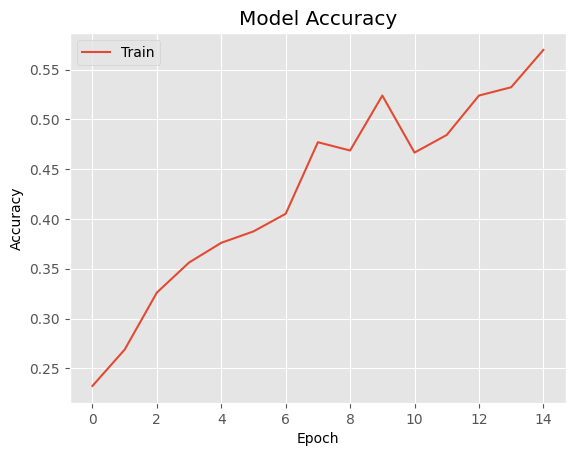

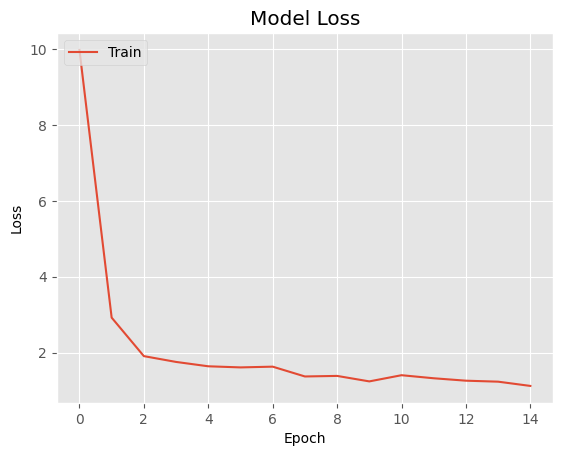

In [22]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()

Will add some more additional data to get more accuracy
https://tspace.library.utoronto.ca/handle/1807/24487

In [23]:
tess_directory = 'TESS Toronto emotional speech set data/'
tess_directory_list = os.listdir(tess_directory)
file_path_list = []
gender_list = []
emotion_label_list = [] 

emotion_dictionary = {
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'angry': 'angry',
    'fear': 'fear',
    'disgust': 'disgust',
}

for directory in tess_directory_list:
    audio_files = os.listdir(os.path.join(tess_directory, directory))
    for audio_file in audio_files:
        file_name_parts = audio_file.split('.')[0].split('_')
        key = file_name_parts[2]
        if key in emotion_dictionary:
            file_path_list.append(f"{tess_directory}{directory}/{audio_file}") 
            gender_list.append('female')  # Female only dataset
            emotion_label_list.append(emotion_dictionary[key])
            
tess_dataframe = pd.DataFrame({
    'file_path': file_path_list,
    'gender_category': gender_list,
    'emotion_label': emotion_label_list
})

tess_dataframe.head()

,file_path,gender_category,emotion_label
0,TESS Toronto emotional speech set data/YAF_dis...,female,disgust
1,TESS Toronto emotional speech set data/YAF_dis...,female,disgust
2,TESS Toronto emotional speech set data/YAF_dis...,female,disgust
3,TESS Toronto emotional speech set data/YAF_dis...,female,disgust
4,TESS Toronto emotional speech set data/YAF_dis...,female,disgust


In [24]:
tess_dataframe['emotion_label'].unique()

array(['disgust', 'happy', 'sad', 'fear', 'angry'], dtype=object)

In [25]:
file_path_list = []
gender_list = []
emotion_label_list = []
crema_path = "./Crema"

emotion_dictionary = {
    "ANG" : "angry",
    "HAP" : "happy",
    "FEA" : "fear" , 
    "SAD" : "sad" , 
    "DIS" : "disgust"
}

actor_dictionary = {
    "1001" : "male" , 
    "1002" : "female" , 
    "1003" : "female" , 
    "1004" : "female" , 
    "1005" : "male", 
    "1006" : "female" , 
    "1007" : "female" , 
    "1008" : "female" , 
    "1009" : "male" , 
    "1010" : "female" , 
    "1011" : "male" , 
    "1012" : "female" , 
    "1013" : "female" , 
    "1014" : "male", 
    "1015" : "male" , 
    "1016" : "male" , 
    "1017" : "male" , 
    "1018" : "female" , 
    "1019" : "male" , 
    "1020" : "female" , 
    "1021" : "female" , 
    "1022" : "male" , 
    "1023" : "male", 
    "1024" : "female" , 
    "1025" : "female" , 
    "1026" : "male" , 
    "1027" : "male" , 
    "1028" : "female" , 
    "1029" : "female" , 
    "1030" : "female" , 
    "1031" : "male" , 
    "1032" : "male", 
    "1033" : "male" , 
    "1034" : "male" , 
    "1035" : "male" , 
    "1036" : "male" , 
    "1037" : "female" , 
    "1038" : "male" , 
    "1039" : "male" , 
    "1040" : "male" , 
    "1041" : "male" , 
    "1042" : "male", 
    "1043" : "female" , 
    "1044" : "male" , 
    "1045" : "male" , 
    "1046" : "female" , 
    "1047" : "female" , 
    "1048" : "male" , 
    "1049" : "female" , 
    "1050" : "male" , 
    "1051" : "male", 
    "1052" : "female" , 
    "1053" : "female" , 
    "1054" : "female" , 
    "1055" : "female" , 
    "1056" : "female" , 
    "1057" : "male" , 
    "1058" : "female" , 
    "1059" : "male" , 
    "1060" : "female", 
    "1061" : "female" , 
    "1062" : "male" , 
    "1063" : "female" , 
    "1064" : "male" , 
    "1065" : "male" , 
    "1066" : "male" , 
    "1067" : "male" , 
    "1068" : "male" , 
    "1069" : "male", 
    "1070" : "male" , 
    "1071" : "male" , 
    "1072" : "female" , 
    "1073" : "female" , 
    "1074" : "female" , 
    "1075" : "female" , 
    "1076" : "female" , 
    "1077" : "male" , 
    "1078" : "female", 
    "1079" : "female" , 
    "1080" : "male" , 
    "1081" : "male" , 
    "1082" : "female" , 
    "1083" : "male" , 
    "1084" : "female" , 
    "1085" : "male" , 
    "1086" : "male" , 
    "1087" : "male", 
    "1088" : "male" , 
    "1089" : "female" , 
    "1090" : "male" , 
    "1091" : "female" , 
}

for audio_file in os.listdir(crema_path):
    file_name_parts = audio_file.split('.')[0].split('_')[2]
    gender_code = audio_file.split('.')[0].split('_')[0]
    if file_name_parts == "NEU":
        pass
    else:
        key = emotion_dictionary[file_name_parts]
        file_path_list.append(f"{crema_path}/{audio_file}")
        gender_list.append(actor_dictionary[gender_code])
        emotion_label_list.append(key)

crema_dataframe = pd.DataFrame({
    'file_path': file_path_list,
    'gender_category': gender_list,
    'emotion_label': emotion_label_list
})

crema_dataframe.head()

,file_path,gender_category,emotion_label
0,./Crema/1022_ITS_ANG_XX.wav,male,angry
1,./Crema/1037_ITS_ANG_XX.wav,female,angry
2,./Crema/1073_IOM_DIS_XX.wav,female,disgust
3,./Crema/1066_IOM_DIS_XX.wav,male,disgust
4,./Crema/1078_IWL_SAD_XX.wav,female,sad


In [26]:
df = pd.concat([ravdess_dataframe, tess_dataframe , crema_dataframe], axis=0).reset_index(drop=True)

In [27]:
df

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
9406,./Crema/1068_DFA_DIS_XX.wav,male,disgust
9407,./Crema/1089_WSI_ANG_XX.wav,female,angry
9408,./Crema/1025_IWW_ANG_XX.wav,female,angry
9409,./Crema/1030_IWW_ANG_XX.wav,female,angry


In [28]:
df['emotion_label'].unique()

array(['angry', 'fear', 'disgust', 'sad', 'happy', 'neutral'],
      dtype=object)

In [29]:
df['file_path'][0]

'./Ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav'

In [30]:
df.head()

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust


In [31]:
df['emotion_label'].value_counts()

emotion_label
angry      1863
fear       1863
disgust    1863
sad        1863
happy      1863
neutral      96
Name: count, dtype: int64

In [32]:
df_train = df[df['emotion_label']!='neutral']
df_train

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
9406,./Crema/1068_DFA_DIS_XX.wav,male,disgust
9407,./Crema/1089_WSI_ANG_XX.wav,female,angry
9408,./Crema/1025_IWW_ANG_XX.wav,female,angry
9409,./Crema/1030_IWW_ANG_XX.wav,female,angry


In [33]:
df_train.emotion_label.unique()

array(['angry', 'fear', 'disgust', 'sad', 'happy'], dtype=object)

In [2]:
df_train = pd.read_csv("df_train.csv")
df_train.drop("Unnamed: 0" , axis=1 , inplace = True)
df_train

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
9310,./Crema/1068_DFA_DIS_XX.wav,male,disgust
9311,./Crema/1089_WSI_ANG_XX.wav,female,angry
9312,./Crema/1025_IWW_ANG_XX.wav,female,angry
9313,./Crema/1030_IWW_ANG_XX.wav,female,angry


In [3]:
# data augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=4)

# taking any example and checking for techniques.
path = np.array(df_train.file_path)[1]
data, sample_rate = librosa.load(path)

In [4]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
X, Y = [], []
for path, emotion in zip(df_train.file_path, df_train.emotion_label):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [36]:
df_train.to_csv("df_train.csv")

In [5]:
import numpy as np

# feature_array = X

file_path = './X.npy'

# Save the array to the specified file
# np.save(file_path, feature_array)

# To load the array back later, you can use:
loaded_array = np.load(file_path)


In [6]:
import pickle

# Assuming 'your_list' is the list you want to save
# label_array = Y

# Specify the file path where you want to save the list
file_path = './label_array.pkl'

# Save the list to the specified file
# with open(file_path, 'wb') as file:
#     pickle.dump(label_array, file)

# To load the list back later, you can use:
with open(file_path, 'rb') as file:
    loaded_list = pickle.load(file)

# Now 'loaded_list' contains the data from the saved file


In [7]:
len(loaded_array), len(loaded_list), df_train.file_path.shape

(27945, 27945, (9315,))

In [8]:
features_df = pd.DataFrame(loaded_array)
features_df['labels'] = loaded_list
features_df.to_csv('features_df.csv', index=False)

In [9]:
df = pd.read_csv("features_df.csv")
df



,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,labels
0,0.204540,0.018793,-440.286560,52.299297,-6.665863,4.278304,-15.808314,-9.869630,-13.956796,-18.327837,...,6.682091e-03,4.037452e-03,4.854841e-03,4.624050e-03,5.723318e-03,6.006947e-03,6.102506e-03,5.150126e-03,2.505069e-04,angry
1,0.275350,0.019038,-352.744976,30.343925,-0.399806,1.631908,-11.421471,-10.797857,-8.836236,-15.042275,...,6.714449e-03,4.084314e-03,4.927430e-03,4.723357e-03,5.820576e-03,6.062932e-03,6.140140e-03,5.221949e-03,3.294476e-04,angry
2,0.249251,0.008652,-489.849182,40.352001,-15.419022,-10.547825,-25.925098,-16.362896,-24.995378,-19.835222,...,2.190899e-03,1.388381e-03,1.012815e-03,1.185204e-03,1.719651e-03,2.396468e-03,2.744122e-03,1.469553e-03,1.402692e-04,angry
3,0.189815,0.012744,-484.020691,52.436253,-8.613789,6.417563,-3.227553,-13.682245,-20.474319,-20.309660,...,2.600971e-03,2.951628e-03,3.851316e-03,3.153920e-03,2.964235e-03,2.586019e-03,2.761167e-03,1.653331e-03,1.145745e-04,fear
4,0.249855,0.012796,-455.946465,42.704516,-3.839698,3.762361,-2.340021,-13.723904,-19.399827,-18.171848,...,2.600527e-03,2.960236e-03,3.855162e-03,3.165024e-03,2.977158e-03,2.591351e-03,2.759111e-03,1.659657e-03,1.187417e-04,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27940,0.153498,0.030200,-278.937077,71.862199,20.031498,23.161638,6.939466,1.149303,-4.914889,-7.767547,...,4.587510e-04,4.785104e-04,4.598921e-04,4.571320e-04,4.405491e-04,4.618232e-04,4.648914e-04,4.894546e-04,4.866626e-04,angry
27941,0.092112,0.015987,-398.641022,103.747620,18.351601,25.855722,-10.868281,-2.027220,-15.630761,-3.193994,...,1.727416e-04,1.536689e-04,1.435634e-04,1.063246e-04,2.996544e-05,6.327445e-07,1.694874e-09,1.443789e-09,9.284063e-10,angry
27942,0.090129,0.044190,-308.637146,120.858704,-8.512693,50.515560,-7.497458,16.173399,-24.176479,11.461170,...,8.355721e-11,6.158026e-11,4.811286e-11,3.921334e-11,3.315207e-11,2.896879e-11,2.609721e-11,2.420980e-11,2.309803e-11,angry
27943,0.340920,0.056570,-117.812071,22.844813,7.214551,5.275518,2.222704,-2.329662,-4.303185,-1.543472,...,5.002652e-02,5.612778e-02,5.547409e-02,5.424513e-02,5.427836e-02,5.293527e-02,5.478158e-02,5.476651e-02,5.250164e-02,angry


In [10]:
X = df.iloc[: ,:-1].values
Y = df['labels'].values

In [11]:
# As this is a multiclass classification problem onehotencoding our Y.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

encoder_path = "./encoder"
with open(encoder_path, 'wb') as encoder_file:
    pickle.dump(encoder , encoder_file)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)



In [13]:
scalar_path = "./scalar"
with open(scalar_path, 'wb') as scalar_file:
    pickle.dump(scaler , scalar_file)

In [14]:
# making our data compatible to model.
X = np.expand_dims(X, axis=2)

In [15]:
X.shape[1]

155

In [16]:
Y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [17]:
print(X.shape,Y.shape)

(27945, 155, 1) (27945, 5)


In [21]:
# Assuming your original array is named 'data'
data = X  # Replace this with your actual data

# Define the new length you want (164 in this case)
new_length = 164

# Calculate the amount of padding needed on each side
padding_left = (new_length - data.shape[1]) // 2
padding_right = new_length - data.shape[1] - padding_left

# Pad the array with zeros along the second axis
X = np.pad(data, ((0, 0), (padding_left, padding_right), (0, 0)), mode='constant', constant_values=0)

# Check the shape of the expanded array
print("Original shape:", data.shape)
print("Expanded shape:", X.shape)

Original shape: (27945, 155, 1)
Expanded shape: (27945, 164, 1)


# CNN + LSTM

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPool1D, BatchNormalization, Activation, Attention, GlobalAveragePooling2D, Reshape, MaxPool1D

# Define the model
model = Sequential()

# Convolutional block 1
model.add(Conv1D(256, 5,  strides= 2, padding='same', input_shape=(164, 1)))
model.add(MaxPool1D(pool_size = 5 , strides = 2 , padding = "same"))
model.add(Dropout(0.2))

# LSTM layer 1
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Convolutional block 1
model.add(Conv1D(128, 5,  strides= 2, padding='same', input_shape=(164, 1)))
model.add(MaxPool1D(pool_size = 5 , strides = 2 , padding = "same"))
model.add(Dropout(0.2))

# LSTM layer 2
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 82, 256)           1536      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 41, 256)           0         
                                                                 
 lstm_12 (LSTM)              (None, 41, 64)            82176     
                                                                 
 dropout_22 (Dropout)        (None, 41, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 21, 128)           41088     
                                                      

In [52]:
history = model.fit(X,Y,epochs=50,batch_size=32)

Epoch 1/50
874/874 [==============================] - 25s 27ms/step - loss: 1.3888 - accuracy: 0.3909 - precision: 0.5594 - recall: 0.0785 - auc: 0.7232
Epoch 2/50
874/874 [==============================] - 23s 26ms/step - loss: 1.2682 - accuracy: 0.4642 - precision: 0.6461 - recall: 0.1957 - auc: 0.7811
Epoch 3/50
874/874 [==============================] - 23s 26ms/step - loss: 1.2039 - accuracy: 0.4949 - precision: 0.6824 - recall: 0.2592 - auc: 0.8053
Epoch 4/50
874/874 [==============================] - 23s 27ms/step - loss: 1.1598 - accuracy: 0.5140 - precision: 0.7076 - recall: 0.2936 - auc: 0.8194
Epoch 5/50
874/874 [==============================] - 23s 27ms/step - loss: 1.1338 - accuracy: 0.5245 - precision: 0.7228 - recall: 0.3079 - auc: 0.8276
Epoch 6/50
874/874 [==============================] - 23s 26ms/step - loss: 1.1065 - accuracy: 0.5323 - precision: 0.7381 - recall: 0.3207 - auc: 0.8361
Epoch 7/50
874/874 [==============================] - 23s 27ms/step - loss: 1.0865

In [53]:
model.save("cnn_lstm.h5")

In [54]:
model.evaluate(X,Y)

874/874 [==============================] - 7s 7ms/step - loss: 0.7743 - accuracy: 0.6887 - precision: 0.8185 - recall: 0.5436 - auc: 0.9235


[0.7742952108383179,
 0.6886741518974304,
 0.8185344934463501,
 0.5436393022537231,
 0.9235144853591919]

# CNN + ATTENTION NET + LSTM

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPool1D, BatchNormalization, Activation, Attention, GlobalAveragePooling2D, Reshape

# Define the model
model = Sequential()

# Convolutional block 1
model.add(Conv1D(512, 5,  strides= 2, padding='same', input_shape=(164, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size= 2))

# Convolutional blocks 2-4
for _ in range(3):
    model.add(Conv1D(256, 5, strides= 2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
# LSTM layer 1
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# LSTM layer 2
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 82, 512)           3072      
                                                                 
 batch_normalization_4 (Bat  (None, 82, 512)           2048      
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 82, 512)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 256)           655616    
                                                                 
 batch_normalization_5 (Bat  (None, 21, 256)          

In [24]:
history = model.fit(X,Y,epochs=50,batch_size=32)

Epoch 1/50
874/874 [==============================] - 61s 70ms/step - loss: 1.1596 - accuracy: 0.5264 - precision: 0.6932 - recall: 0.3032 - auc: 0.8218
Epoch 2/50
874/874 [==============================] - 65s 75ms/step - loss: 1.0410 - accuracy: 0.5756 - precision: 0.7423 - recall: 0.3872 - auc: 0.8580
Epoch 3/50
874/874 [==============================] - 70s 80ms/step - loss: 0.9849 - accuracy: 0.6055 - precision: 0.7597 - recall: 0.4315 - auc: 0.8735
Epoch 4/50
874/874 [==============================] - 66s 76ms/step - loss: 0.9473 - accuracy: 0.6173 - precision: 0.7671 - recall: 0.4493 - auc: 0.8832
Epoch 5/50
874/874 [==============================] - 65s 74ms/step - loss: 0.9087 - accuracy: 0.6331 - precision: 0.7745 - recall: 0.4750 - auc: 0.8927
Epoch 6/50
874/874 [==============================] - 66s 76ms/step - loss: 0.8766 - accuracy: 0.6454 - precision: 0.7854 - recall: 0.4992 - auc: 0.9006
Epoch 7/50
874/874 [==============================] - 67s 77ms/step - loss: 0.8336

In [25]:
model.save("cnn-attention-model.h5")

In [118]:
# dir(model)

In [26]:
model.evaluate(X,Y)

874/874 [==============================] - 13s 14ms/step - loss: 0.3066 - accuracy: 0.8925 - precision: 0.9008 - recall: 0.8843 - auc: 0.9872


[0.30660390853881836,
 0.8925031423568726,
 0.9008493423461914,
 0.884344220161438,
 0.9871770143508911]

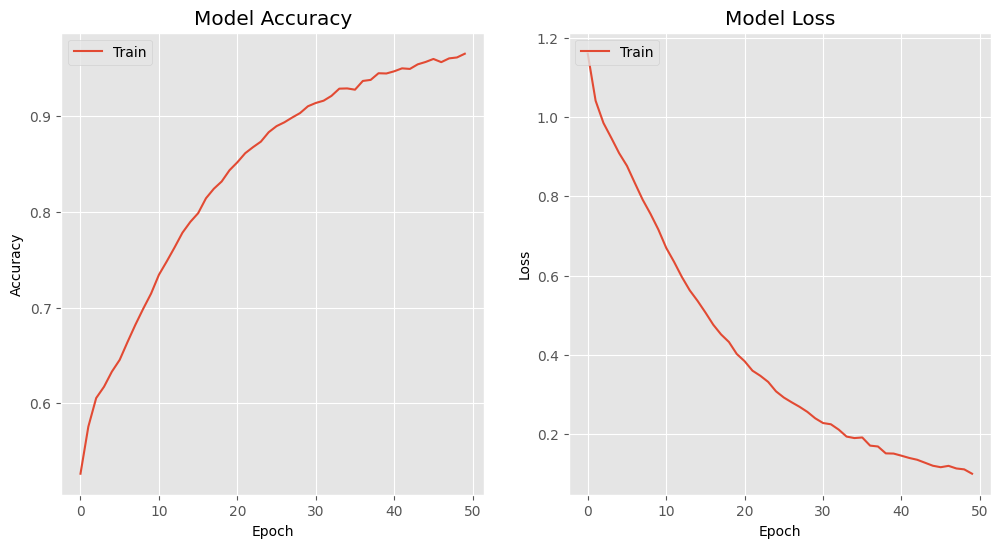

In [30]:
plt.figure(figsize=(12, 6))

# Plot Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.show()


# ANN

In [64]:
model = Sequential()

model.add(Dense(256, activation='relu' , input_shape = (X.shape[1] , )))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


In [65]:
history = model.fit(X,Y,epochs=50,batch_size=32)

Epoch 1/50
874/874 [==============================] - 1s 1ms/step - loss: 1.2466 - accuracy: 0.4783 - precision: 0.7091 - recall: 0.2259 - auc: 0.7908
Epoch 2/50
874/874 [==============================] - 1s 962us/step - loss: 1.0867 - accuracy: 0.5519 - precision: 0.7569 - recall: 0.3313 - auc: 0.8433
Epoch 3/50
874/874 [==============================] - 1s 976us/step - loss: 1.0315 - accuracy: 0.5737 - precision: 0.7713 - recall: 0.3711 - auc: 0.8593
Epoch 4/50
874/874 [==============================] - 1s 1ms/step - loss: 0.9998 - accuracy: 0.5897 - precision: 0.7751 - recall: 0.3903 - auc: 0.8685
Epoch 5/50
874/874 [==============================] - 1s 1ms/step - loss: 0.9750 - accuracy: 0.5967 - precision: 0.7779 - recall: 0.4075 - auc: 0.8749
Epoch 6/50
874/874 [==============================] - 1s 1ms/step - loss: 0.9594 - accuracy: 0.6030 - precision: 0.7814 - recall: 0.4177 - auc: 0.8792
Epoch 7/50
874/874 [==============================] - 1s 953us/step - loss: 0.9427 - accur

In [66]:
model.save("ann-model.h5")

# More ann

In [89]:
model = Sequential()

model.add(Dense(256, activation='relu' , input_shape = (X.shape[1] , )))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


In [90]:
history = model.fit(X,Y,epochs=50,batch_size=32)

Epoch 1/50
874/874 [==============================] - 2s 1ms/step - loss: 1.3887 - accuracy: 0.3921 - precision: 0.6998 - recall: 0.1164 - auc: 0.7233
Epoch 2/50
874/874 [==============================] - 1s 1ms/step - loss: 1.2001 - accuracy: 0.4959 - precision: 0.7428 - recall: 0.2468 - auc: 0.8057
Epoch 3/50
874/874 [==============================] - 1s 1ms/step - loss: 1.1281 - accuracy: 0.5327 - precision: 0.7727 - recall: 0.2983 - auc: 0.8292
Epoch 4/50
874/874 [==============================] - 1s 1ms/step - loss: 1.0846 - accuracy: 0.5504 - precision: 0.7895 - recall: 0.3275 - auc: 0.8434
Epoch 5/50
874/874 [==============================] - 1s 1ms/step - loss: 1.0604 - accuracy: 0.5615 - precision: 0.7925 - recall: 0.3403 - auc: 0.8499
Epoch 6/50
874/874 [==============================] - 1s 1ms/step - loss: 1.0399 - accuracy: 0.5697 - precision: 0.7954 - recall: 0.3528 - auc: 0.8563
Epoch 7/50
874/874 [==============================] - 1s 2ms/step - loss: 1.0173 - accuracy: 0

In [91]:
model.save("more-ann.h5")

# ANN + LSTM

In [41]:
model3 = Sequential()
model3.add(LSTM(256, input_shape=(X.shape[1],1), return_sequences=False))  # LSTM layer added

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))  # Adding dropout for regularization

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))  # Adding dropout for regularization

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))  # Adding dropout for regularization

model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [42]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               264192    
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)               

In [43]:
history = model3.fit(X,Y,epochs=50,batch_size=32)

Epoch 1/50
874/874 [==============================] - 156s 177ms/step - loss: 1.5320 - accuracy: 0.3034 - precision: 0.5063 - recall: 0.0244 - auc: 0.6314
Epoch 2/50
874/874 [==============================] - 147s 168ms/step - loss: 1.4744 - accuracy: 0.3378 - precision: 0.5673 - recall: 0.0397 - auc: 0.6686
Epoch 3/50
874/874 [==============================] - 150s 171ms/step - loss: 1.4824 - accuracy: 0.3340 - precision: 0.5771 - recall: 0.0430 - auc: 0.6636
Epoch 4/50
874/874 [==============================] - 148s 169ms/step - loss: 1.4605 - accuracy: 0.3458 - precision: 0.5793 - recall: 0.0477 - auc: 0.6781
Epoch 5/50
874/874 [==============================] - 149s 170ms/step - loss: 1.4305 - accuracy: 0.3625 - precision: 0.5918 - recall: 0.0574 - auc: 0.6957
Epoch 6/50
874/874 [==============================] - 164s 187ms/step - loss: 1.4334 - accuracy: 0.3583 - precision: 0.6067 - recall: 0.0592 - auc: 0.6927
Epoch 7/50
874/874 [==============================] - 155s 178ms/step 

In [44]:
model3.save("ann_lstm.h5")

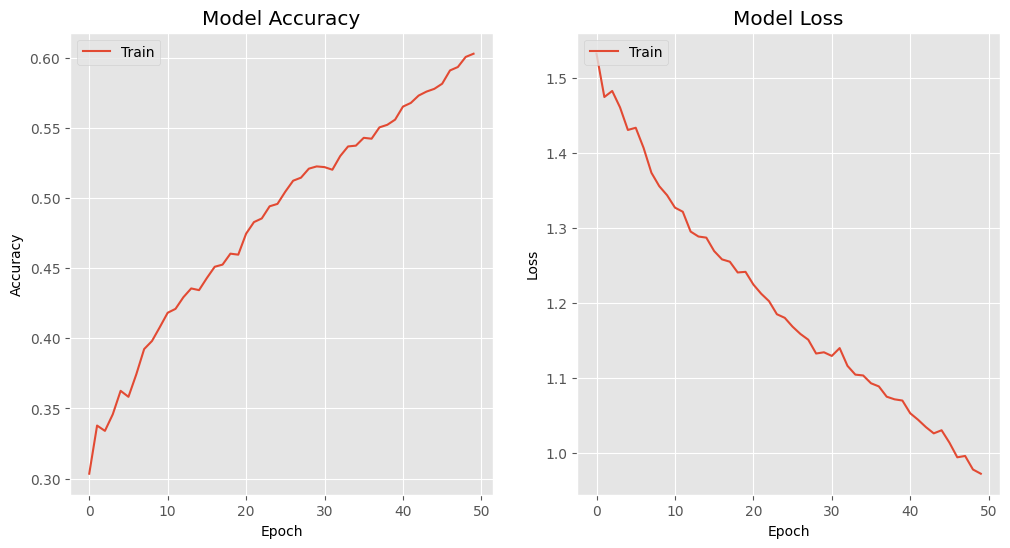

In [45]:
plt.figure(figsize=(12, 6))

# Plot Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.show()


# ANN + MORE LAYERS OF LSTM

In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential()

# LSTM layers
model.add(LSTM(256, input_shape=(X.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Print the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 164, 128)          66560     
                                                                 
 dropout_16 (Dropout)        (None, 164, 128)          0         
                                                                 
 batch_normalization_8 (Bat  (None, 164, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_10 (LSTM)              (None, 164, 64)           49408     
                                                                 
 dropout_17 (Dropout)        (None, 164, 64)           0         
                                                                 
 batch_normalization_9 (Bat  (None, 164, 64)           256       
 chNormalization)                                     

In [47]:
history = model.fit(X,Y,epochs=50,batch_size=32)

Epoch 1/50
874/874 [==============================] - 134s 149ms/step - loss: 1.6729 - accuracy: 0.2574 - precision: 0.3197 - recall: 0.0410 - auc: 0.5699
Epoch 2/50
874/874 [==============================] - 131s 150ms/step - loss: 1.5098 - accuracy: 0.3149 - precision: 0.5121 - recall: 0.0393 - auc: 0.6439
Epoch 3/50
874/874 [==============================] - 128s 146ms/step - loss: 1.4540 - accuracy: 0.3487 - precision: 0.5264 - recall: 0.0527 - auc: 0.6811
Epoch 4/50
874/874 [==============================] - 130s 149ms/step - loss: 1.4233 - accuracy: 0.3700 - precision: 0.5199 - recall: 0.0677 - auc: 0.7011
Epoch 5/50
874/874 [==============================] - 128s 147ms/step - loss: 1.4085 - accuracy: 0.3789 - precision: 0.5427 - recall: 0.0864 - auc: 0.7092
Epoch 6/50
874/874 [==============================] - 130s 149ms/step - loss: 1.3721 - accuracy: 0.3968 - precision: 0.5760 - recall: 0.1150 - auc: 0.7285
Epoch 7/50
874/874 [==============================] - 128s 146ms/step 

In [49]:
model.save("ann_more_lstm.h5")

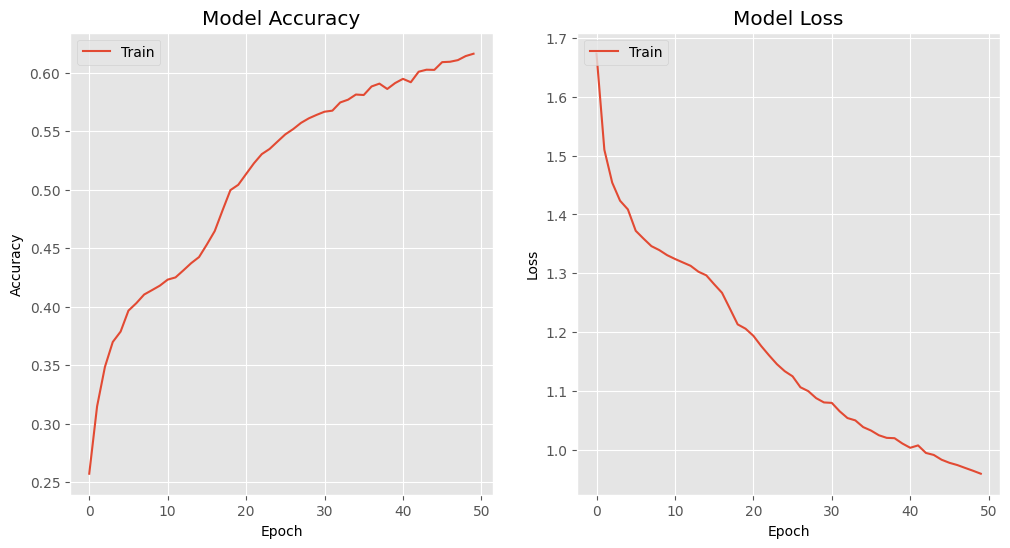

In [50]:
plt.figure(figsize=(12, 6))

# Plot Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.show()
